This notebook is a combination of python/bash commands one needs to perform SPECT simulation and reconstruction using STIR. Note that scatter can not be simulated in STIR (though the triple energy window method can be used for scatter estimation when performing reconstruction on data that does have scatter).

Everything can be one, provided this notebook is ran in the STIR environment. To set this up

1. Download anaconda
2. Follow these instructions to make the proper environment for STIR https://stir.sourceforge.net/wiki/index.php/Installing_STIR_with_conda
3. Make sure this notebook is ran using the `stirenv` kernel (this could amount to opening a terminal, `conda activate stirenv`, then `jupyter notebook` if you want to run this in jupyter)

In [1]:
import numpy as np
import matplotlib.pyplot as plt

In general, the entire imaging process can be written as 

$$g = \mathcal{H}f + n$$

where 

* $f(x,y,z)$ is a vector that represents the number of counts at $(x,y,z)$
* $\mathcal{H}$ is a linear operator that represents the imaging process
* $g(\theta, r, z)$ is a vector that represents a given projection (function of $(r,z)$) at angle $\theta$
* $n$ is noise (usually Poisson)

We will use this convention for all naming of files.

In practice, one only has access to $g$ when imaging. One can get an estimate for $f$ using

$$\hat{f} = A(g)$$

where $A$ is a reconstruction algorithm. In this notebook, we will use the standard OSEM, but this can be generalized to more complicated algorithm. In this video we will simulate

1. The imaging process $g = \mathcal{H}f + n$
2. The reconstruction process $\hat{f} = A(g)$

# The Imaging Process

First will generate a 3D mask of a cylinder given by

$$f = \begin{cases} 5 & x^2 + z^2 < 0.5^2 \hspace{3mm} \text{and} \hspace{3mm} -0.5<y<0.5\\
 0 & \text{else}\end{cases}$$

In [2]:
zv, yv, xv = np.meshgrid(np.linspace(-1,1,128), np.linspace(-1,1,128), np.linspace(-1,1,128), indexing='ij')
f = 5 * (xv**2 + zv**2 < 0.5**2) * (yv<0.5) * (yv>-0.5)

We can then look at various cross sections

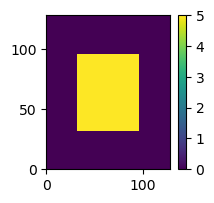

In [59]:
plt.figure(figsize=(2,2))
plt.pcolormesh(f[:,:,60])
plt.colorbar()

We now need to save this data to the appropriate format so that it can be opened in STIR. We can now begin to look at the files in the `SPECT_files` folder. 
* STIR uses *interfile* format which expects both a header file and a binary file for every data array. The convention used in this repo is that .hv and .v are used for headers and binary data of object data (i.e. $f$) and .hs and .s are used for headers and binary data of projection data (i.e. $g$).
* Since we are creating this binary data ourselves, *in general, we need to create the header file ourselves as well*. In this case I've provided it. You can open `f.hv` to see all the required fields needed for STIR. When you are dealing with data in the future, you will need to create these header files yourselves and that pertain to your data.
* The header file `f.hv` specifies that each data point is 4 *bytes* so we need to ensure its saved as a 32 *bit* float (8 bits = 1 byte).
* The header file expects the matrix to be in (z,y,x) index order. We have created it as such (i.e. `f[50]` selects the 50th z slice, `f[:,50]` selects the 50th y slice, and `f[:,:,50]` selects the 50th x slice)


Now we create the file `f.v` which pertains to the header file `f.hv`. 

In [3]:
f.astype(np.float32).tofile('SPECT_files/f.v')

Now we can simulate the imaging process $g = \mathcal{H} f + n$. In STIR, one simulates $g = \mathcal{H}f$ first, and then adds the noise after.

* Stir uses `.par` files to specify any parameters regarding the forward projection (i.e. imaging process). The file `H.par` contains all information needed here. In such a parameter file, a semicolon ";" is a commented out line, and an exclamation mark ! has no effect on the line. 
* The `H.par` file specifies both the point spread function (PSF) and the attenuation information. In this case, we'll assume no attenuation, but one can add an attenuation file (notebook will be updated later)
* The `template_g.hs` file is a template for the collected sinogram data $g$. It specifies the pixel size of the detectors and where the detectors are located relative to the patient. It also specifies the number of projections (i.e. $\Delta \theta$)

When the bash command below is ran, it generates `g.hs` and `g.s`: the header file/data of the projection $g$ To see specifications about its arguments, run `!forward_project` in a seperate cell

In [6]:
!forward_project SPECT_files/g.hs SPECT_files/f.hv SPECT_files/template_g.hs SPECT_files/H.par


INFO: 2D PSF Correction. Parallel geometry

Parameters of SPECT UB matrix: (in cm)
Image grid side row: 128	col: 128	transverse voxel_size: 0.2
Number of slices: 128	slice_thickness: 0.2
Number of bins: 128	bin size: 0.2	axial size: 0.2
Number of angles: 24	Angle increment: 15	First angle: 180
Number of subsets: 24
Rotation radii: {15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15}
Minimum weight: 0


INFO: Done estimating size of matrix. Execution (CPU) time 1.11 s 

INFO: Processing view 6 of segment 0

INFO: Processing view 1 of segment 0

INFO: Processing view 0 of segment 0

INFO: Processing view 2 of segment 0

INFO: Processing view 5 of segment 0

INFO: Processing view 3 of segment 0

INFO: Processing view 7 of segment 0

INFO: Processing view 4 of segment 0

INFO: Computing matrix elements for view 6

INFO: total number of non-zero weights in this view: 20386560, estimated size: 195.984 MB

INFO: Weight matrix calculation done. time

Now we add $n$ to $g$ using the `poisson_noise` command of STIR. Again, this is run in bash:

In [7]:
!poisson_noise -p g_noise.hs g.hs 1 1

Now we can open up the binary data of the projections in numpy

* Note the order the binary array is stored ($\theta$, $r$, $z$)

In [8]:
g = np.fromfile('g_noise.s', dtype=np.float32).reshape((24,128,128))

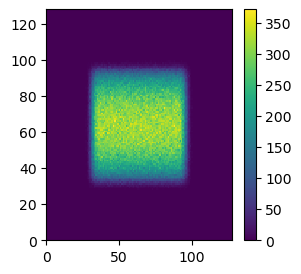

In [9]:
plt.figure(figsize=(3,3))
plt.pcolormesh(g[18])
plt.colorbar()

Reconstruction in STIR also requires `.par` files. In this case, we use the `OSEM.par` file in the `SPECT_files` folder. This takes into account the PSF, and runs OSEM with 2 subsets for 8 iterations. We are not adjusting for attenuation here:

In [11]:
!OSMAPOSL SPECT_files/OSEM.par


INFO: osmaposlparameters :=
output filename prefix := f_recon
output file format type := Interfile
interfile output file format parameters :=
byte order := LITTLEENDIAN
number format := float
number of bytes per pixel := 4
scale to write data := 0
end interfile output file format parameters := 

post-filter type := None
disable output := 0
verbosity := -1
objective function type := PoissonLogLikelihoodWithLinearModelForMeanAndProjData
poissonloglikelihoodwithlinearmodelformeanandprojdata parameters :=
prior type := None
sensitivity filename := 
subset sensitivity filenames := 
recompute sensitivity := 0
use subset sensitivities := 1
input file := g_noise.hs
maximum absolute segment number to process := -1
zero end planes of segment 0 := 0
zoom := 1
z zoom := 0.5
xy output image size (in pixels) := 128
z output image size (in pixels) := 128
z offset (in mm) := 0
projector pair type := Matrix
projector pair using matrix parameters :=
matrix type := SPECT UB
projection matrix by bin spec

Then we can open the reconstructed image

In [15]:
f_recon = np.fromfile('f_recon_8.v', dtype=np.float32).reshape((128,128,128))

And can compare the original to the reconstruction

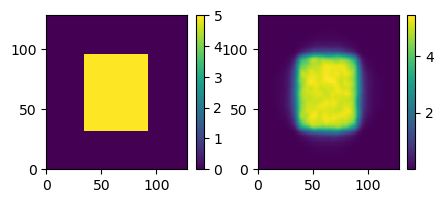

In [16]:
plt.subplots(1,2, figsize=(5,2))
plt.subplot(121)
plt.pcolormesh(f[50])
plt.colorbar()
plt.subplot(122)
plt.pcolormesh(f_recon[50])
plt.colorbar()

Text(0.5, 0, 'X')

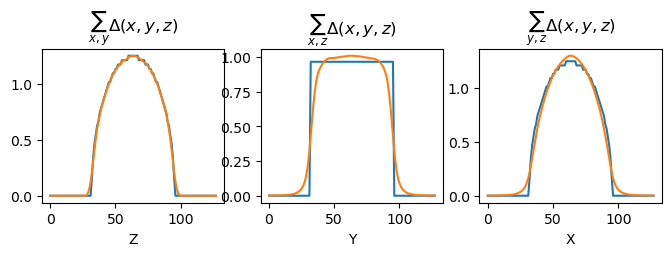

In [17]:
plt.subplots(1, 3, figsize=(8,2))
plt.subplot(131)
plt.title('$\sum_{x,y}\Delta (x,y,z)$')
plt.plot(f.mean(axis=(1,2)))
plt.plot(f_recon.mean(axis=(1,2)))
plt.xlabel('Z')
plt.subplot(132)
plt.title('$\sum_{x,z}\Delta (x,y,z)$')
plt.plot(f.mean(axis=(0,2)))
plt.plot(f_recon.mean(axis=(0,2)))
plt.xlabel('Y')
plt.subplot(133)
plt.title('$\sum_{y,z}\Delta (x,y,z)$')
plt.plot(f.mean(axis=(0,1)))
plt.plot(f_recon.mean(axis=(0,1)))
plt.xlabel('X')